# Import package

In [1]:
import numpy as np
import pyjet
from pyjet import cluster
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import uproot
import h5py


# Define function for jet rotation

In [2]:
def flatten(event): # for single event in order to reshape data
#     fp = np.concatenate((np.expand_dims(event[0], axis=-1),
#                          np.expand_dims(event[1], axis=-1),
#                          np.expand_dims(event[2], axis=-1),
#                          np.expand_dims(event[3], axis=-1)), axis=-1)
#     fp = fp.transpose((1,0))
    fp = event
    fp = np.core.records.fromarrays( [fp[:,0],fp[:,1],fp[:,2],fp[:,3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')

    return fp

def jet_clustering(event, R0, p = -1):
    # R0 = Clustering radius for the main jets
    flattened_event = flatten(event)
    ## p = -1, 0, 1 => anti-kt, C/A, kt Algorithm
    sequence = cluster(flattened_event, R=R0, p= p)
    # List of jets
    jets = sequence.inclusive_jets()
    return jets

def struc2arr(x):
    # pyjet outputs a structured array. This converts
    # the 4 component structured array into a simple
    # 4xN numpy array
    x = x.view((float, len(x.dtype.names)))
    return x

def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp


def jet_rotate(event, R0 = 0.2,  p = 1):
    # R0 = Clustering radius for the main jets
    flattened_event = flatten(event)
    ## p = -1, 0, 1 => anti-kt, C/A, kt Algorithm
    sequence = cluster(flattened_event, R=R0, p= p)
    # List of jets
    jets = sequence.inclusive_jets()
    if len(jets)<2:
        return []
    else:
        subjet_data = event
        subjet_array = jets
        
        
#         subjet_data = jets.constituents_array()
#         subjet_data = struc2arr(subjet_data)
        pT = subjet_data[:, 0]
        eta = subjet_data[:, 1]
        phi = subjet_data[:, 2]
        mass = subjet_data[:, 3]
        
        # Shift all data such that the leading subjet
        #jet new center is located at (eta,phi) = (0,0)
        eta -= subjet_array[0].eta
        phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])
        
        
        # Rotate the jet image such that the second leading
        # jet is located at -pi/2
        s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)
        
        theta = np.arctan2(s1y, s1x)
        if theta < 0.0:
            theta += 2 * np.pi
        eta, phi = rotate(eta, phi, np.pi - theta)
        
        # Collect the trimmed subjet constituents
        rjcs = np.array([pT, eta, phi, mass])
        rjcs = np.expand_dims(rjcs, axis=-1)
        rjcs = rjcs.transpose((1,0,2))
        rjcs = np.squeeze(rjcs, axis=(2,))
        return rjcs



## These function is data dependent, so you need to map your data in case

In [3]:
##------------calculate jet constituents energy, if you already had this information don't use it.
def jce_np(jcpt, jceta, jcmass):
    jcp = jcpt*np.cosh(jceta)
    return (jcp**2+jcmass**2)**0.5


#-------- attach integers to your keys  this example is : 'index' -> 0-th data, 'JCPT' ->1-th data
# and 'index' is event index
# 'JCPT' is constituents transvers momentum (PT)
# 'JCETA' is constituents ETA
# 'JCPHI' is constituents angle around beam axis
# 'Ncontituents' is Number of constituents in the jet which the constitunt belong
# 'constiteunts_index' is constituents index in each jet ('constiteunts' is typo)
# 'JCDELTAETA' is constituents ETA related to jet axis
# 'JCDELTAPHI' is constituents ETA related to jet axis
# 'PT' is transvers momentum (PT) of jet which which the constitunt belong
# 'ETA' is ETA of jet which which the constitunt belong
# 'PHi' is PHI of jet which which the constitunt belong


_index, _jcpt, _jceta, _jcphi, _jcmass, _Ncons, _consindex, _jcdelteta, _jcdeltphi, _jpt, _jeta, _jphi = (i for i in range(12))
Labels = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Ncontiteunts', 'constiteunts_index', 'JCDELTETA', 'JCDELTPHI', 'PT', 'ETA', 'PHI']

##--------------------------------------------------h5py file to ParticleNet input structure
def h5_to_JET(h5path):
    f = h5py.File(h5path,'r')
    fc = np.array([f[lb][()] for lb in Labels])
    fc = fc.transpose((1,0))
    Nj = set(fc[:,_index].astype(np.int))
    
    
    events = np.array([fc[:,_jcpt],
                       fc[:,_jceta],
                       fc[:,_jcphi],
                       fc[:,_jcmass]  
                      ])
    
    # just reshape data
    events = np.expand_dims(events, axis=-1)
    events = events.transpose((1,0,2))
    events = np.squeeze(events,axis=(2,))
    
    jets = []
    R0 = 0.5
    # for j in tqdm(range(Nj)):
    for j in tqdm(Nj):
        if not any(fc[:,_index]==j):
            continue
        event = events[fc[:,_index]==j]
        jr = jet_rotate(event)
        if len(jr) ==0:
            continue
        jets.append(jr)
    return jets


# Check key words in h5 file

In [4]:
f = h5py.File("/home/james/LHE_test/H5/SVJ/rinv03/0Trimjetc.h5",'r')
f.keys()

<KeysViewHDF5 ['ETA', 'JCDELTETA', 'JCDELTPHI', 'JCETA', 'JCMASS', 'JCPHI', 'JCPT', 'MASS', 'Ncontiteunts', 'PHI', 'PT', 'constiteunts_index', 'index']>

# Prepare plot function

In [5]:
from scipy.stats import binned_statistic_2d
    

In [6]:
def pixelize(jet, bins = 64, R = 1.2):
    pt, eta, phi = jet[:,0], jet[:,1], jet[:,2]

    # Define the binning for the complete calorimeter
    ranges = np.array([[-R,R],[-R,R]])

    # Sum energy deposits in each bin
    digitized = binned_statistic_2d(eta, phi, pt, statistic="sum", bins=bins, range= ranges)
#     digitized = binned_statistic_2d(eta, phi, pt, statistic="sum", bins=bins)
    
    jet_image = digitized.statistic
    return jet_image


# Rotate jet and plot data

100%|██████████| 7330/7330 [00:02<00:00, 3424.90it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


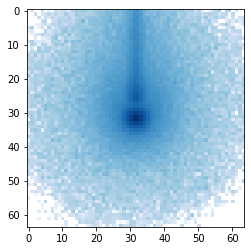

In [7]:
jims = []
jets = h5_to_JET("/home/james/LHE_test/H5/SVJ/rinv03/0Trimjetc.h5")
for i in tqdm(range(len(jets))):
    jim = pixelize(jets[i])
    jims.append(jim)
jims = np.array(jims)
jim = np.sum(jims, axis = 0)
plt.imshow(np.log(jim),  cmap = 'Blues')

# Befor rotation

In [8]:
def h5_to_nonrJET(h5path):
    f = h5py.File(h5path,'r')
    fc = np.array([f[lb][()] for lb in Labels])
    fc = fc.transpose((1,0))
    Nj = set(fc[:,_index].astype(np.int))
    
    
    events = np.array([fc[:,_jcpt],
                       fc[:,_jcdelteta],
                       fc[:,_jcdeltphi],
                       fc[:,_jcmass]  
                      ])
    
    # just reshape data
    events = np.expand_dims(events, axis=-1)
    events = events.transpose((1,0,2))
    events = np.squeeze(events,axis=(2,))
    
    jets = []
    R0 = 0.5
    # for j in tqdm(range(Nj)):
    for j in tqdm(Nj):
        if not any(fc[:,_index]==j):
            continue
        event = events[fc[:,_index]==j]
        jets.append(event)
    return jets

100%|██████████| 7869/7869 [00:02<00:00, 3494.75it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


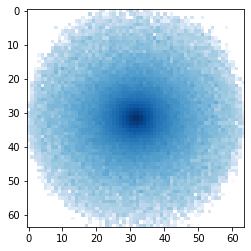

In [9]:
jims = []
jets = h5_to_nonrJET("/home/james/LHE_test/H5/SVJ/rinv03/0Trimjetc.h5")
for i in tqdm(range(len(jets))):
    jim = pixelize(jets[i])
    jims.append(jim)
jims = np.array(jims)
jim = np.sum(jims, axis = 0)
plt.imshow(np.log(jim),  cmap = 'Blues')